<a href="https://colab.research.google.com/github/channy33/CV_pjt/blob/master/mkimg_%EB%A7%88%EC%8A%A4%ED%81%AC%EC%9E%88%EC%9D%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False #그리드 안쓸것

import tensorflow as tf
import numpy as np
import PIL.Image
import time
#import functools

In [ ]:
#

import cv2

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [130]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [131]:
content_path = tf.keras.utils.get_file('png_chanyoung3.png',
'https://raw.githubusercontent.com/channy33/CV_pjt/e323776675cda0f935cf09cc557f1ca950645af8/png_chanyoung3.png')


style_path = tf.keras.utils.get_file('png_klimt.PNG',
'https://raw.githubusercontent.com/channy33/CV_pjt/a24e892efdc9ede3fe7c712dc15ced0496d4cbae/png_klimt.PNG')

In [132]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [133]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

1.0
(1, 512, 379, 3)
(1, 512, 512, 3)


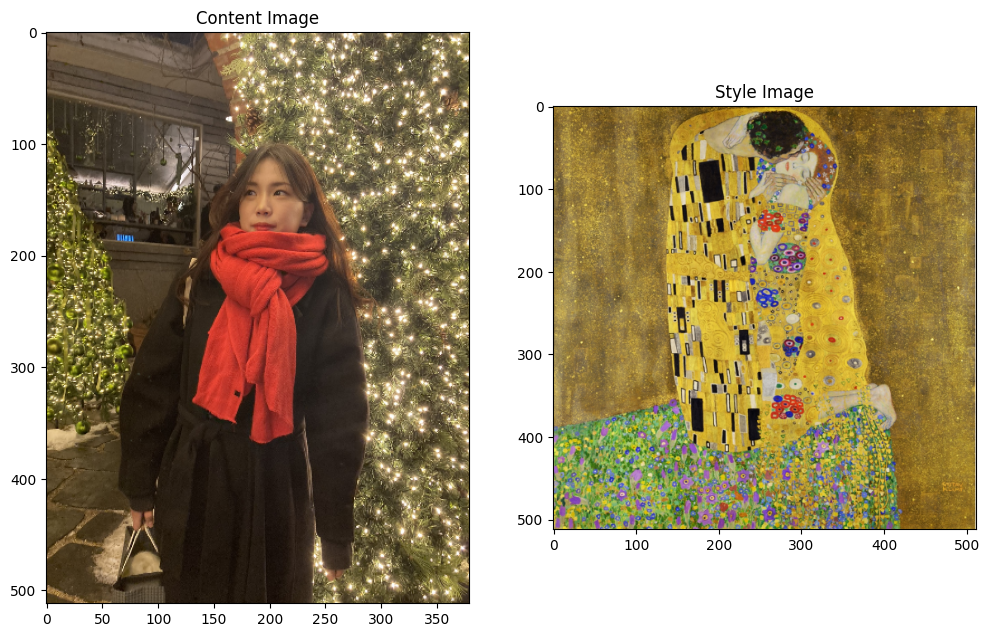

In [134]:
content_image = load_img(content_path)
max_value=np.max(content_image)
print(max_value)
style_image = load_img(style_path)
print(content_image.shape)
print(style_image.shape)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [135]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224)) #원래 vgg19s는 224*224로 되어있어서, 픽셀사이즌 관련없음
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

(1, 1000)


[('abaya', 0.32440662),
 ('cloak', 0.29927123),
 ('poncho', 0.06504377),
 ('stole', 0.058601867),
 ('trench_coat', 0.015963444)]

In [136]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

#block5_conv2로 레이어 선택하여 스타일 전이 시킬 층 선택


input_30
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [137]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(content_layers+style_layers)

['block5_conv2', 'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']


In [138]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')#
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model(vgg.input, outputs)
  return model


In [139]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.shape)

block1_conv1
  shape:  (1, 512, 512, 64)
block2_conv1
  shape:  (1, 256, 256, 128)
block3_conv1
  shape:  (1, 128, 128, 256)
block4_conv1
  shape:  (1, 64, 64, 512)
block5_conv1
  shape:  (1, 32, 32, 512)


In [140]:
def gram_matrix(input_tensor):
  result = tf.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [141]:
a=np.random.random((2,3,4,5)) #ijkl
b=np.random.random((2,3,4,9)) #ijkp
c=tf.einsum('ijkl,ijkp->ip',a,b) #->ip
print(c.shape)
#모르겠으면 찾아가보면서 하시오

(2, 9)


In [142]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False #trainable 하지마라!

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [143]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(content_image)

print('style:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("shape", output.shape)

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("shape", output.shape)

style:
   block1_conv1
shape (1, 64, 64)
   block2_conv1
shape (1, 128, 128)
   block3_conv1
shape (1, 256, 256)
   block4_conv1
shape (1, 512, 512)
   block5_conv1
shape (1, 512, 512)
콘텐츠:
   block5_conv2
shape (1, 32, 23, 512)


In [144]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [145]:
image = tf.Variable(content_image) #미분가능하도록 variable로함
#constant는 미분못함

In [146]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [147]:
#아담w쓰기
opt = tf.keras.optimizers.AdamW(learning_rate=0.02, weight_decay=1e-4, beta_1=0.99, epsilon=1e-1)

#opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1) #아담w써도 됨

In [148]:
#손실함수 적용
style_weight=1e-2
content_weight=1e4

In [149]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

마스크생성


In [ ]:
# 얼굴 검출 및 마스크 생성
def create_face_mask(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    mask = Image.new("L", (img.shape[1], img.shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    for (x, y, w, h) in faces:
        draw.rectangle([x, y, x+w, y+h], fill=255)

    return mask

mask = create_face_mask(content_path)
mask = mask.resize(content_image.shape[1:3])
mask = np.array(mask) / 255.0
mask = tf.convert_to_tensor(mask, dtype=tf.float32)

In [150]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
  return image

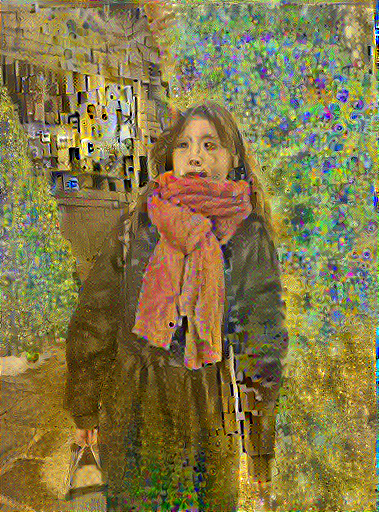

훈련 스텝: 1000
전체 소요 시간: 74.5


In [151]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

styled_image = tensor_to_image(image)
display.display(styled_image)

원래 사진자체도 뒷배경이 화려한 사진이여야 해당화풍이 잘담긴다
